## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras._tf_keras.keras import layers, models
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras._tf_keras.keras.losses import SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import EarlyStopping

## Set Constant Values

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

## Download or load the dataset 

In [3]:
training = "Data/Corn leaf deseases/train/"
testing = "Data/Corn leaf deseases/test/"

## Image Preprocessing

### Create Dataset for train,test,validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 3348 files belonging to 4 classes.
Using 2679 files for training.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 840 files belonging to 4 classes.
Using 168 files for validation.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 3348 files belonging to 4 classes.
Using 669 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


## Visualize the data

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

In [9]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.93725413


## Resize and Rescale

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(0.1 / 256)
])

## Data Augmentation

In [13]:
data_augmentation  = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

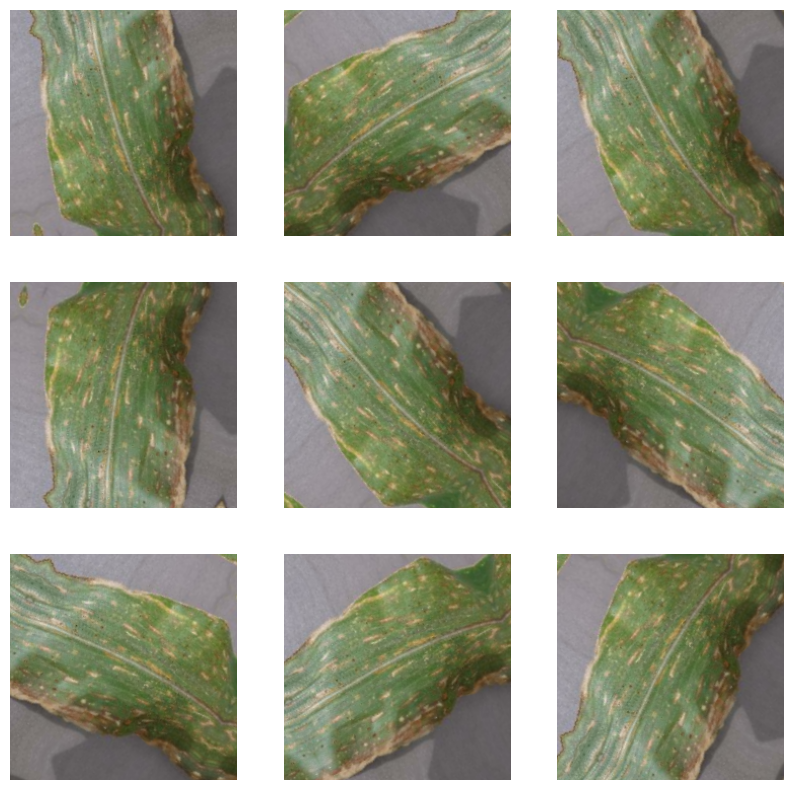

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Define the EarlyStopping callback

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# EfficientNet Model Implementation

Import the base model

In [16]:
from keras._tf_keras.keras.applications.efficientnet_v2 import EfficientNetV2B0

Create a base model

In [18]:
conv_base = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
)
conv_base.trainable = False

Add Connected layers to EfficientNet Base

In [20]:
model_eff = Sequential()
resize_and_rescale
model_eff.add(conv_base)
model_eff.add(Flatten())
model_eff.add(Dense(256,activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(BatchNormalization())
model_eff.add(Dense(num_classes,activation='sigmoid'))
model_eff.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,977,940 (83.84 MB)

 Trainable params: 16,058,116 (61.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

Add early_stopping

Compile the model

In [22]:
model_eff.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Train the model

In [23]:
epochs = 5
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8051 - loss: 0.5522 - val_accuracy: 0.8984 - val_loss: 0.2705
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8878 - loss: 0.2962 - val_accuracy: 0.9088 - val_loss: 0.2182
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9091 - loss: 0.2340 - val_accuracy: 0.9312 - val_loss: 0.1665
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9266 - loss: 0.1990 - val_accuracy: 0.9268 - val_loss: 0.1854
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9330 - loss: 0.1826 - val_accuracy: 0.9357 - val_loss: 0.1449
Restoring model weights from the end of the best epoch: 5.


### Evaluate the model

In [24]:
model_eff.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step - accuracy: 0.9433 - loss: 0.1615


[0.15008193254470825, 0.9523809552192688]

# Visualize training results

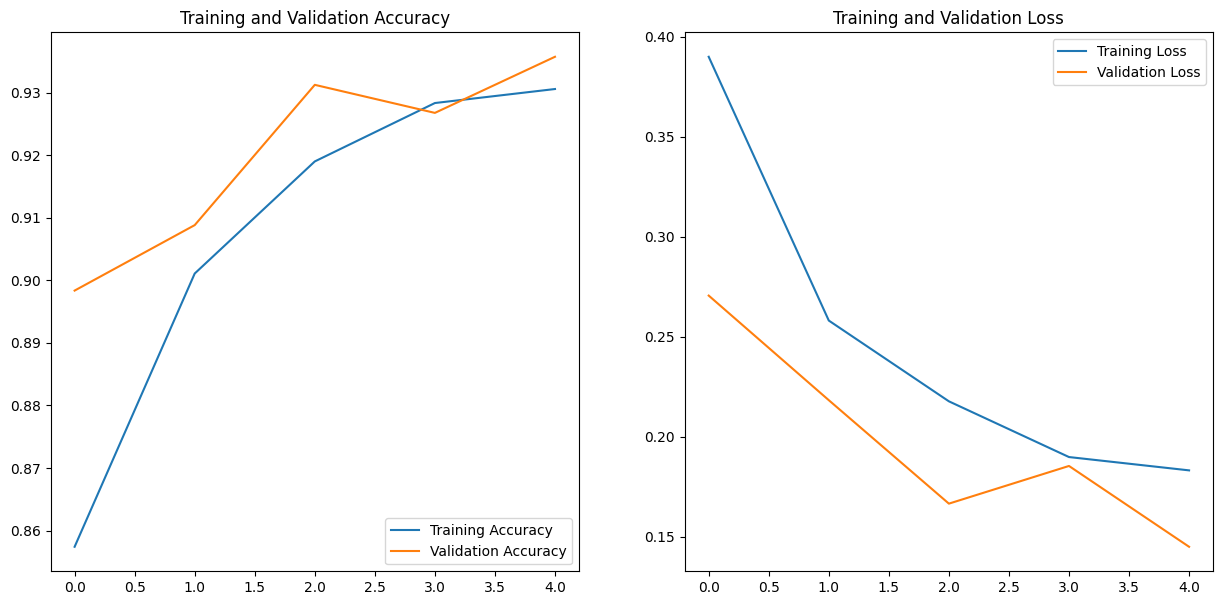

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [26]:
model_eff.save("Model EfficientNet.keras")

# CNN Model Implementation

Model Layering 

In [17]:
model_CNN = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

Compile the model

In [18]:
model_CNN.compile(
    optimizer='adam',
    loss= "sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,348 (12.62 MB)

 Trainable params: 3,309,348 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

Train the model


In [19]:
epochs = 30
history = model_CNN.fit(
  train_ds,
  epochs=epochs, 
  validation_data=val_ds,
  batch_size=BATCH_SIZE
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 567ms/step - accuracy: 0.5692 - loss: 1.0676 - val_accuracy: 0.8326 - val_loss: 0.5060
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 567ms/step - accuracy: 0.8192 - loss: 0.4340 - val_accuracy: 0.8326 - val_loss: 0.5062
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 564ms/step - accuracy: 0.8373 - loss: 0.3889 - val_accuracy: 0.8341 - val_loss: 0.4365
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 565ms/step - accuracy: 0.8361 - loss: 0.3713 - val_accuracy: 0.8251 - val_loss: 0.4098
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 567ms/step - accuracy: 0.8750 - loss: 0.3286 - val_accuracy: 0.8371 - val_loss: 0.4032
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 570ms/step - accuracy: 0.8570 - loss: 0.3452 - val_accuracy: 0.8445 - val_loss: 0.4597
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 563ms/step - accuracy: 0.8606 - loss: 0.3344 - val_accuracy: 0.8520 - val_loss: 0.3766
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 631ms/step - accuracy: 0.8762 - loss: 0.2979 - val_accu

Evaluate the model

In [20]:
model_CNN.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9165 - loss: 0.1895


[0.19254246354103088, 0.9226190447807312]

# Visualize Training Results

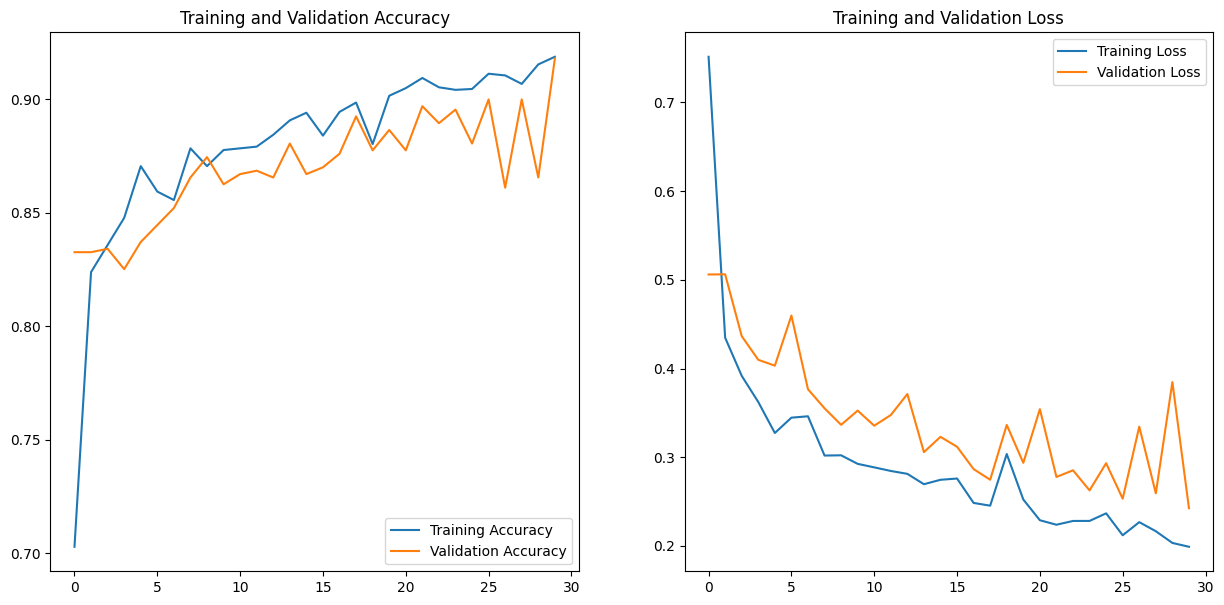

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model 

In [22]:
model_CNN.save('CNN Model.keras')

# VGG19 Model Implementation

Imoport the base model

In [23]:
from keras._tf_keras.keras.applications.vgg19 import VGG19

Create a base model

In [24]:
conv_base = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
)
conv_base.trainable = False

Add connected layers to VGG19 base

In [25]:
model_vgg = Sequential()
resize_and_rescale
model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256,activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(num_classes,activation='sigmoid'))
model_vgg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,449,220 (100.90 MB)

 Trainable params: 6,424,324 (24.51 MB)

 Non-trainable params: 20,024,896 (76.39 MB)

Compile the model

In [26]:
model_vgg.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [29]:
epochs = 5
history = model_vgg.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1042s 12s/step - accuracy: 0.8964 - loss: 0.2649 - val_accuracy: 0.8999 - val_loss: 0.2375
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1009s 12s/step - accuracy: 0.8960 - loss: 0.2617 - val_accuracy: 0.9028 - val_loss: 0.2330
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1029s 12s/step - accuracy: 0.9082 - loss: 0.2484 - val_accuracy: 0.9103 - val_loss: 0.2142
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1046s 12s/step - accuracy: 0.9136 - loss: 0.2259 - val_accuracy: 0.8969 - val_loss: 0.2953
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1019s 12s/step - accuracy: 0.9163 - loss: 0.2065 - val_accuracy: 0.8386 - val_loss: 0.7394
Restoring model weights from the end of the best epoch: 3.


Evaluate the model

In [30]:
model_vgg.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.9026 - loss: 0.2785


[0.26192834973335266, 0.9166666865348816]

# Visualize the Training results

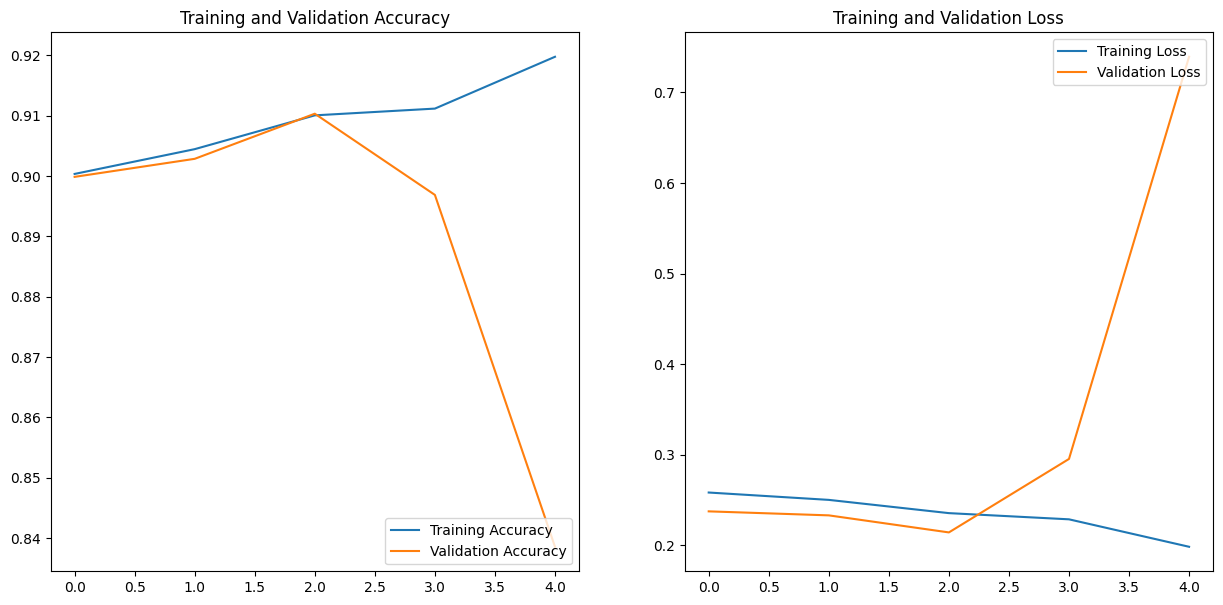

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [32]:
model_vgg.save('Model VGG19.keras')